In [1]:
# Adapted from
# https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/11.multi-label-text-classification-with-bert.ipynb

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch import nn
from collections import defaultdict
import lightning.pytorch as pl
import torch
import numpy as np

2023-04-18 23:58:09.732978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
cards = pd.read_json("data/cards.json")
cards

,name,rules_text,colors,color_identity,flavour_text,type_line,power,toughness,set
0,Static Orb,"As long as CARDNAME is untapped, players can't...","[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 1]",NaN,Artifact,None,None,7ed
1,Sensory Deprivation,Enchant creature\nEnchanted creature gets <-3/...,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",NaN,Enchantment — Aura,None,None,m14
2,Road of Return,Choose one —\n• Return target permanent card f...,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0]",NaN,Sorcery,None,None,c19
3,Storm Crow,Flying (This creature can't be blocked except ...,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",NaN,Creature — Bird,1,2,9ed
4,Walking Sponge,tap: Target creature loses your choice of fly...,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",NaN,Creature — Sponge,1,1,ulg
...,...,...,...,...,...,...,...,...,...
25132,Devoted Hero,,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]",NaN,Creature — Elf Soldier,1,2,s99
25133,Without Weakness,Target creature you control gains indestructib...,"[0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0]",NaN,Instant,None,None,hou
25134,Firesong and Sunspeaker,Red instant and sorcery spells you control hav...,"[1, 0, 0, 1, 0, 0]","[1, 0, 0, 1, 0, 0]",NaN,Legendary Creature — Minotaur Cleric,4,6,2x2
25135,"Samut, the Tested",+1: Up to one target creature gains double str...,"[0, 0, 0, 1, 1, 0]","[0, 0, 0, 1, 1, 0]",NaN,Legendary Planeswalker — Samut,None,None,hou


In [4]:
import spacy

en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

def text_preprocess(input_text):
    # remove all stop words
    input_text = ' '.join([word for word in input_text.split() if word not in stopwords])

    input_text = ''.join([char for char in input_text if char.isalnum() or char == '/' or char == ' '])

    return input_text

X = []
Y = []

# input_text = type_line + rules_text (if not None) + power / toughness (if not None)
for index, card in cards.iterrows():

    input_text = card['type_line']
    if card['rules_text'] is not None:
        input_text += '\n' + card['rules_text']
    if card['power'] is not None:
        input_text += '\n' + card['power'] + '/' + card['toughness']

    input_text = text_preprocess(input_text)
    
    X.append(input_text)
    Y.append(card["color_identity"])

2023-04-18 23:58:12.280662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:58:12.281650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:58:12.281841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

nr_of_targets= 5

# Remove colorless from array and convert from int to float32
y_train = [np.asarray(y)[0:nr_of_targets].astype('float32').ravel() for y in y_train] 
y_test = [np.asarray(y)[0:nr_of_targets].astype('float32').ravel() for y in y_test]
y_val = [np.asarray(y)[0:nr_of_targets].astype('float32').ravel() for y in y_val]

In [6]:
maxlen = 50

# Testing Bert tokenizer on the dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

inputs = tokenizer.batch_encode_plus(
            x_train,
            None,
            max_length= maxlen,
            padding = 'max_length',
            return_token_type_ids= False, 
            return_attention_mask= True,#diff normal/pad tokens
            truncation= True,# Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )

In [7]:
# Example of tokens
inputs['input_ids'][0]

tensor([13832, 18546, 22668,  1409,  2629,  2561, 22559,  1116,  1654,  8743,
         3059, 22559,  1116,  1939,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [8]:
# Converting tokens back to text
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].squeeze()))

['En', '##chan', '##tment', 'If', 'effect', 'create', 'token', '##s', 'control', 'creates', 'twice', 'token', '##s', 'instead', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [9]:
# Wrapping the data into a Torch Dataset. This can be used for training in torch
class CardDataset (Dataset):
    def __init__(self, cards, colors, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.cards = cards
        self.labels = colors
        self.max_len = max_len
        
    def __len__(self):
        return len(self.cards)
    
    def __getitem__(self, item_idx):
        text = self.cards[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
               
        return {
          'text': text,
          'input_ids': input_ids ,
          'attention_mask': attn_mask,
          'labels':torch.tensor(self.labels[item_idx],dtype= torch.float)
        }

In [10]:
# Creating dataset using training data
train_dataset = CardDataset(
  x_train, y_train,
  tokenizer,
  max_len=50
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [11]:
sample_item["text"]

'Enchantment If effect create tokens control creates twice tokens instead'

In [12]:
sample_item["labels"]

tensor([1., 0., 0., 0., 0.])

In [13]:
# The training, validation and test datasets are warped into a lightning.pytorch.LightningDataModule
class CardDataModule (pl.LightningDataModule):
    
    def __init__(self,x_train,y_train,x_val,y_val,x_test,y_test,tokenizer, batch_size=32,max_token_len=50):
        super().__init__()
        self.train_text = x_train
        self.train_label = y_train
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    # Setup the datasets used during training/testing
    def setup(self, stage):
        self.train_dataset = CardDataset(cards=self.train_text, colors=self.train_label, tokenizer=self.tokenizer,max_len= self.max_token_len)
        self.val_dataset= CardDataset(cards=self.val_text, colors=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset = CardDataset(cards=self.test_text, colors=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)

    # Create Torch DataLoaders for the 3 datasets 
    def train_dataloader(self):
         return DataLoader(self.train_dataset,batch_size= self.batch_size, shuffle = True)
    def val_dataloader(self):
         return DataLoader (self.val_dataset,batch_size= self.batch_size)
    def test_dataloader(self):
         return DataLoader (self.test_dataset,batch_size= self.batch_size)

In [14]:
# Define parameters
N_EPOCHS = 4
BATCH_SIZE = 12
MAX_LEN = 50

# Create the DataModule
card_data_module = CardDataModule(x_train, y_train, x_val, y_val, x_test, y_test, tokenizer, BATCH_SIZE, MAX_LEN)

In [15]:
# The lightning.pytorch.LightningModule is the model that will be trained
# Includes the pretrained Bert module as well as an additional Linear layer for our classification
class CardClassifier(pl.LightningModule):
    # Set up the classifier        
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
            
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)    
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )

        return dict(
          optimizer=optimizer,
          lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
          )
        )

In [16]:
# Verify that CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
# Load the final checkpoint from file
trained_model = CardClassifier.load_from_checkpoint(
  'checkpoints/best-checkpoint.ckpt',
  n_classes=nr_of_targets
)
trained_model = trained_model.to(device)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
predictions = []
labels = []

# Create predictions for our test data. This might take 1-2 minutes
for i in range(len(x_test)):
    encoding = tokenizer.encode_plus(
      x_test[i],
      add_special_tokens=True,
      max_length=50,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    _, prediction = trained_model(encoding["input_ids"].to(device), encoding["attention_mask"].to(device))
    
    predictions.append(prediction.flatten())
    labels.append(torch.from_numpy(y_test[i]))
    
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [19]:
labels

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1.]])

In [20]:
predictions

tensor([[0.0080, 0.0029, 0.8183, 0.6126, 0.0047],
        [0.0573, 0.0149, 0.0040, 0.0061, 0.9031],
        [0.1357, 0.2012, 0.7005, 0.0013, 0.0084],
        ...,
        [0.0245, 0.9751, 0.0085, 0.0093, 0.0072],
        [0.0368, 0.0185, 0.0173, 0.0659, 0.9704],
        [0.0289, 0.0397, 0.9867, 0.0652, 0.4432]])

In [21]:
from torchmetrics import Accuracy

# Calculate Accuracy
accuracy = Accuracy(task='multilabel', num_labels=nr_of_targets, threshold=0.5)
print("Accuracy: ", accuracy(predictions, labels))

Accuracy:  tensor(0.9418)


In [22]:
from sklearn.metrics import classification_report

LABELS = ["w", "u", "b", "r", "g"]

y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABELS, 
  zero_division=0
))

              precision    recall  f1-score   support

           w       0.88      0.82      0.85       512
           u       0.92      0.77      0.84       534
           b       0.89      0.85      0.87       582
           r       0.90      0.85      0.87       542
           g       0.91      0.81      0.86       527

   micro avg       0.90      0.82      0.86      2697
   macro avg       0.90      0.82      0.86      2697
weighted avg       0.90      0.82      0.86      2697
 samples avg       0.78      0.75      0.76      2697



In [23]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
print(confusion_matrix)

[[[1946   56]
  [  94  418]]

 [[1944   36]
  [ 121  413]]

 [[1872   60]
  [  87  495]]

 [[1919   53]
  [  82  460]]

 [[1943   44]
  [  99  428]]]


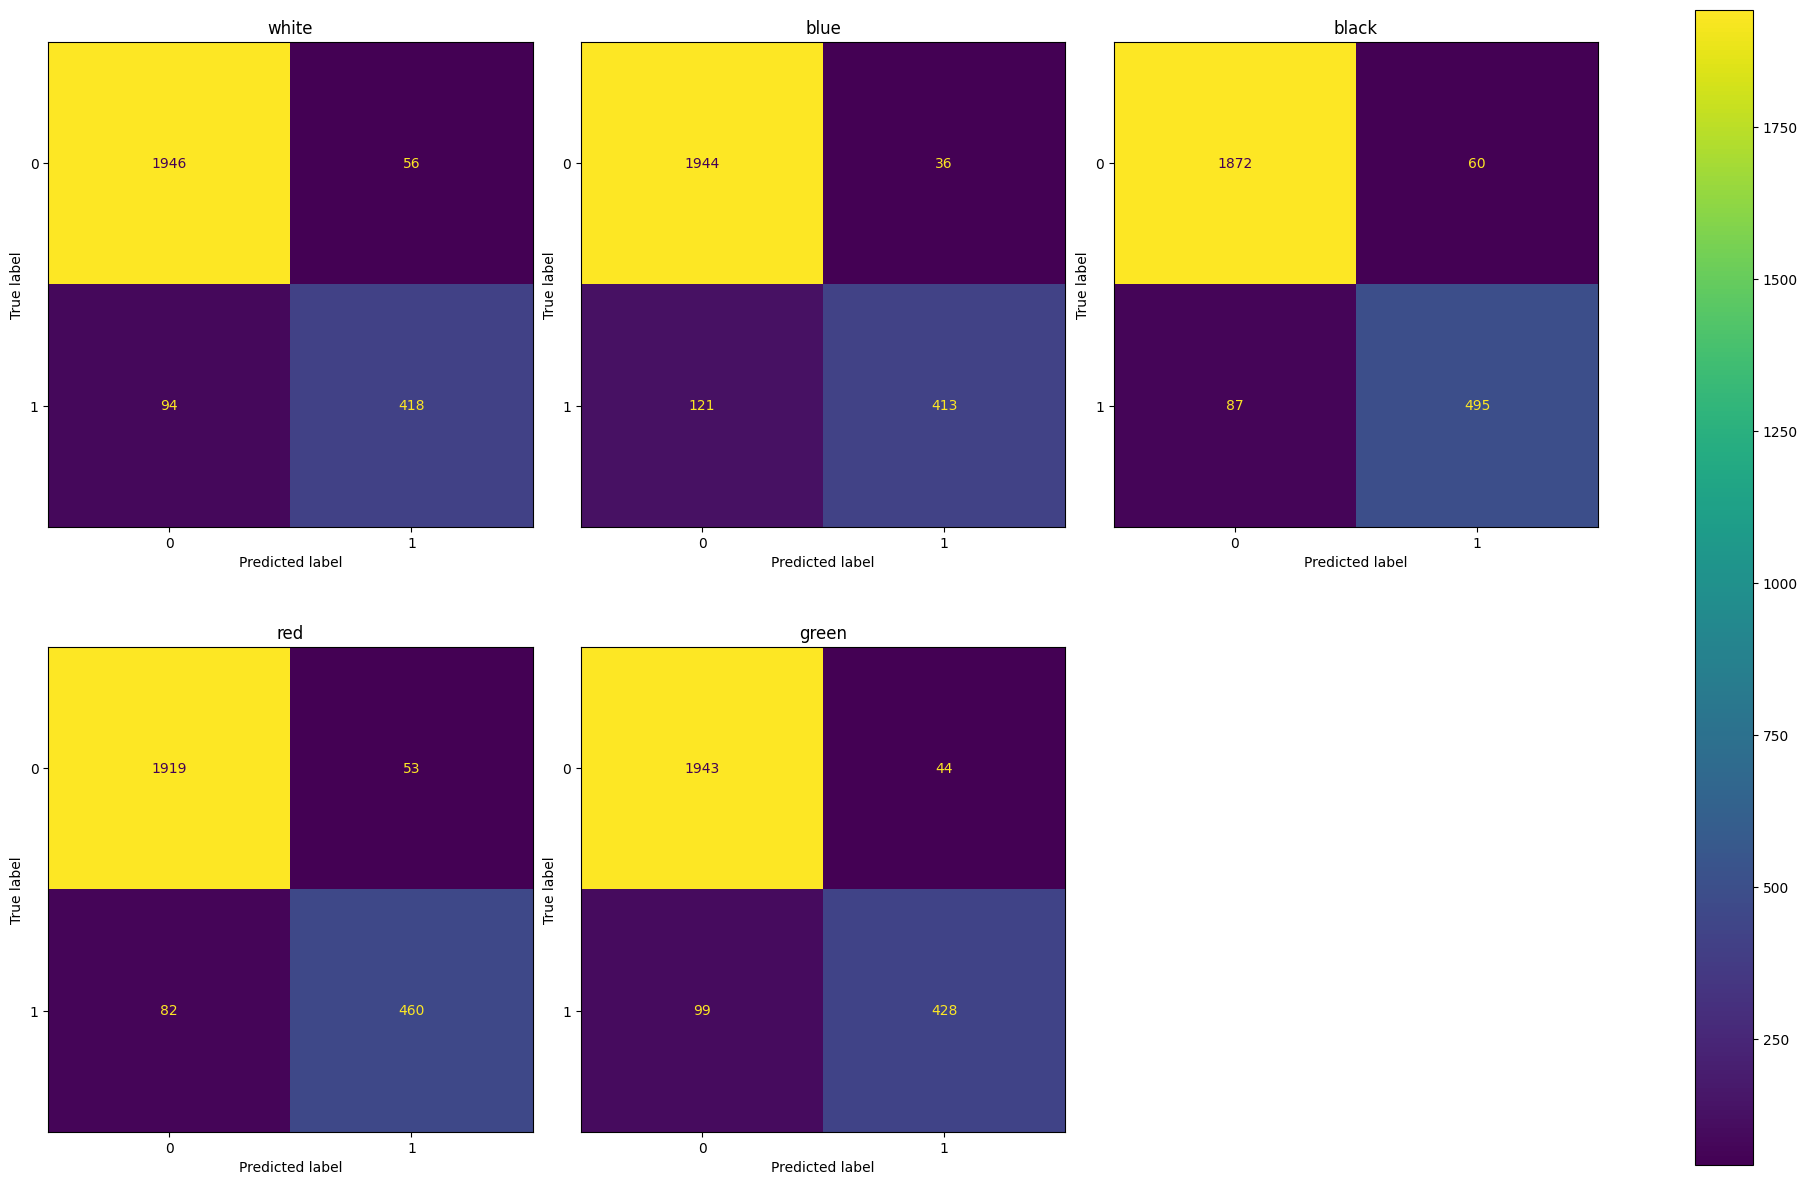

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

classes=['white', 'blue', 'black', 'red', 'green']

fig = plt.figure(figsize=(25, 15))

axes = []
for i in range(5):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, 1])
    ax= fig.add_subplot(2,3,i + 1)
    axes.append(ax)
    disp.plot(ax=ax, values_format='.4g')
    disp.ax_.set_title(classes[i])    
    disp.im_.colorbar.remove()
    

plt.subplots_adjust(wspace=0.10, hspace=0.1)
fig.colorbar(disp.im_, ax=axes)
plt.show()

In [25]:
# Show some prediction samples
import random

for i in random.sample(range(len(x_test)), 10):
    test_text = x_test[i]
    
    encoding = tokenizer.encode_plus(
      test_text,
      add_special_tokens=True,
      max_length=50,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )

    _, test_prediction = trained_model(encoding["input_ids"].to(device), encoding["attention_mask"].to(device))
    test_prediction = test_prediction.cpu().flatten().numpy()
    
    
    formatted_y_test = ["%.3f"%item for item in y_test[i]]
    formatted_prediction = ["%.3f"%item for item in test_prediction]
    
    print("Card text: ", test_text)
    print("Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]")
    print("Actual colors:   ", formatted_y_test)
    print("Predicted colors:", formatted_prediction)
    print()

Card text:  Instant Counter target spell Search controllers graveyard hand library cards spell exile them Then player shuffles
Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '1.000', '0.000', '0.000', '0.000']
Predicted colors: ['0.025', '0.971', '0.021', '0.004', '0.009']

Card text:  Artifact 3 tap Put 1/1 counter target creature
Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '0.000', '0.000', '0.000', '0.000']
Predicted colors: ['0.006', '0.006', '0.008', '0.007', '0.015']

Card text:  Instant Target opponent sacrifices creature flying
Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '0.000', '0.000', '0.000', '1.000']
Predicted colors: ['0.047', '0.040', '0.029', '0.028', '0.740']

Card text:  Legendary Creature  Azra Warlock Menace Whenever sacrifice creature pay  If do draw card  paid  1 Sacrifice creature CARDNAME gains indestructible end turn 4/3
